# Multivariate Linear Models

In [1]:
import  warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sns.set()

## Spurious Association

### 5.1

In [4]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["MedianAgeMarriage_s"] = (d["MedianAgeMarriage"] - d["MedianAgeMarriage"].mean())/d["MedianAgeMarriage"].std()

In [5]:
with pm.Model() as m5_1:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_1 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:14<00:00, 1495.57draws/s]


### 5.2

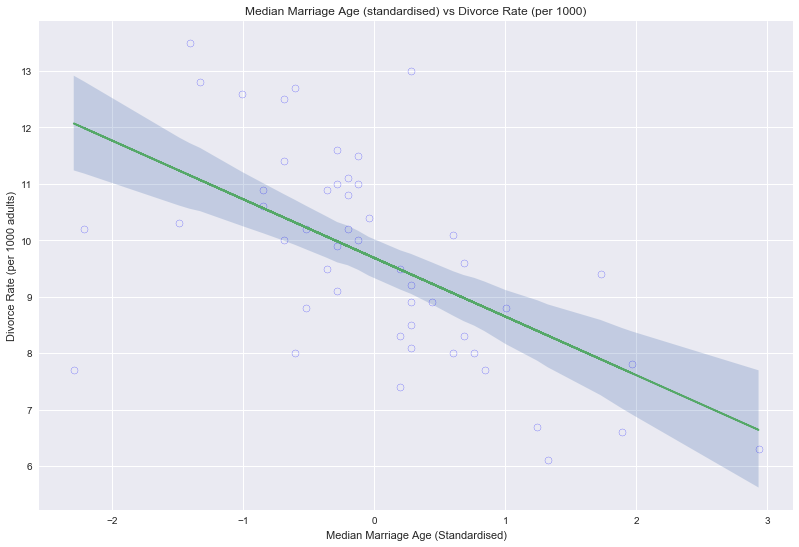

In [6]:
mu_mean = trace_5_1["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["MedianAgeMarriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["MedianAgeMarriage_s"], mu_mean.mean(0))

idx = np.argsort(d["MedianAgeMarriage_s"])
ax.fill_between(d["MedianAgeMarriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Median Marriage Age (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Median Marriage Age (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.3

In [7]:
d["Marriage_s"] = (d["Marriage"] - d["Marriage"].mean())/d["Marriage"].std()

In [8]:
with pm.Model() as m5_2:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["Marriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_2 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:17<00:00, 1287.18draws/s]


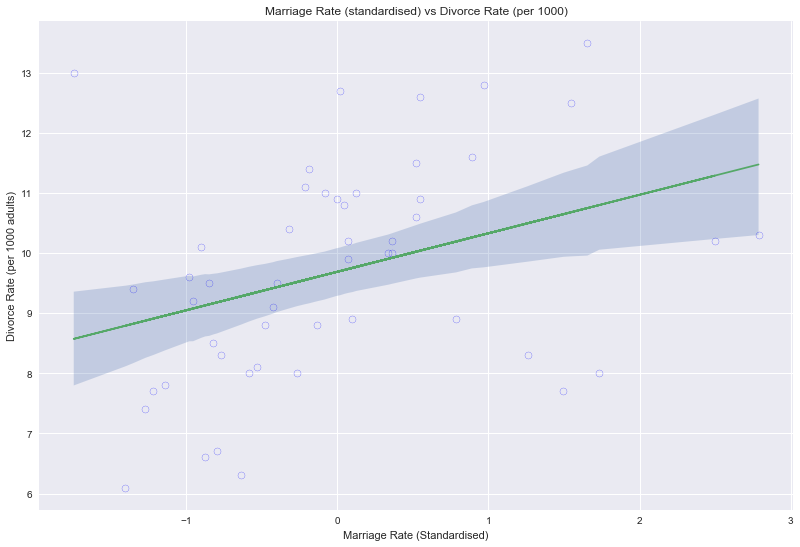

In [9]:
mu_mean = trace_5_2["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["Marriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["Marriage_s"], mu_mean.mean(0))

idx = np.argsort(d["Marriage_s"])
ax.fill_between(d["Marriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Marriage Rate (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Marriage Rate (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.4

In [10]:
with pm.Model() as m5_3:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)    
    bR = pm.Normal("bR", mu=0, sd=1)    
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bR * d["Marriage_s"]) + bA * d["MedianAgeMarriage_s"]
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_3 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:24<00:00, 911.82draws/s] 


In [11]:
pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.687785,0.216633,0.001545,9.345222,10.038127,18887.812808,0.999967
bR,-0.124573,0.295278,0.002418,-0.612304,0.329193,14396.264255,1.000002
bA,-1.123736,0.294545,0.002289,-1.595167,-0.655464,14628.186587,1.000089
sigma,1.524578,0.162629,0.001313,1.261813,1.765897,15203.250143,0.999975


### 5.5

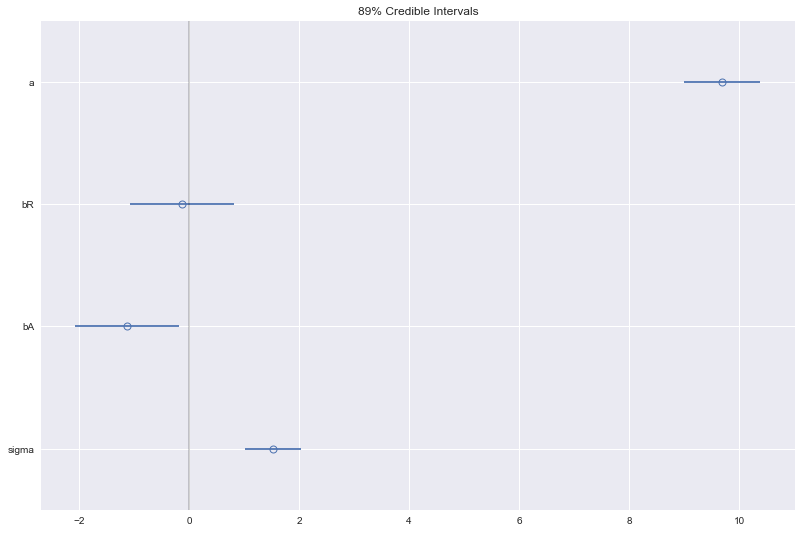

In [12]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.6

In [13]:
with pm.Model() as m5_4:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b = pm.Normal("b", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + b * d["MedianAgeMarriage_s"])
    Marriage_s = pm.Normal("Marriage_s", mu=mu, sd=sigma, observed=d["Marriage_s"])
    trace_5_4 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:15<00:00, 1433.62draws/s]


### 5.7

In [14]:
mu = trace_5_4["mu"].mean(0)
m_resid = d["Marriage_s"] - mu

### 5.8

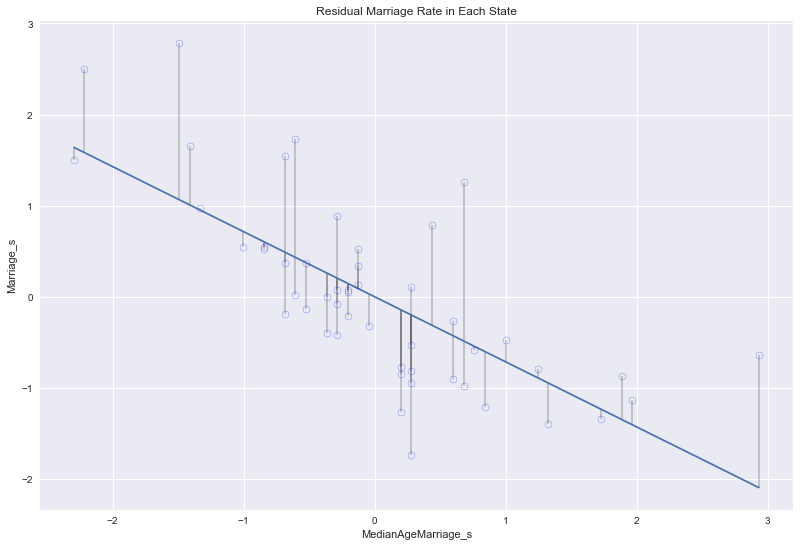

In [15]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
idx = np.argsort(d["MedianAgeMarriage_s"])
ax.plot(d["MedianAgeMarriage_s"][idx], mu[idx])
ax.vlines(d["MedianAgeMarriage_s"], mu, mu + m_resid, alpha=0.2)
ax.plot(d["MedianAgeMarriage_s"], mu + m_resid, "o", mew=0.2, mec="b", mfc="None")
ax.set_title("Residual Marriage Rate in Each State")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Marriage_s");

### 5.9

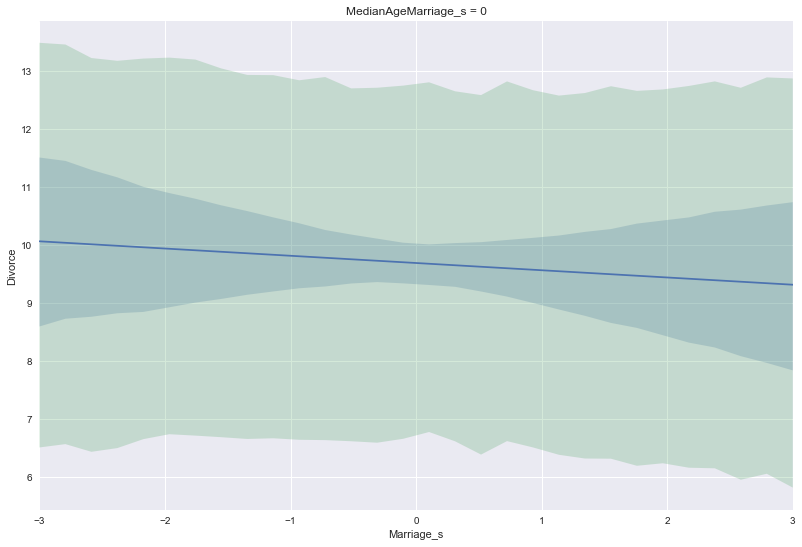

In [16]:
A_avg = d["MedianAgeMarriage_s"].mean()
R_seq = np.linspace(-3, 3, 30)

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"] * A_avg).reshape(-1, 1) +\
     (trace_5_3["bR"].reshape(-1, 1) * R_seq)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

R_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
R_pi = pm.hpd(R_sim)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(R_seq, mu_mean)
ax.fill_between(R_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(R_seq, R_pi[:,0], R_pi[:,1], alpha=0.25)
ax.set_title("MedianAgeMarriage_s = 0")
ax.set_xlabel("Marriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.10

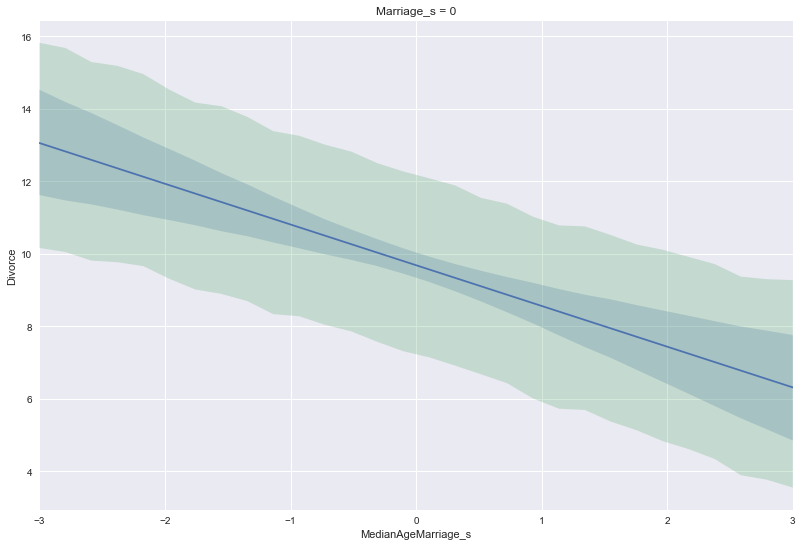

In [17]:
A_seq = np.linspace(-3, 3, 30)
R_avg = d["Marriage_s"].mean()

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"].reshape(-1, 1) * A_seq) +\
     (trace_5_3["bR"] * R_avg).reshape(-1, 1)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

A_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
A_pi = pm.hpd(A_sim, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(A_seq, mu_mean)
ax.fill_between(A_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(A_seq, A_pi[:,0], A_pi[:,1], alpha=0.25)
ax.set_title("Marriage_s = 0")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.11

In [18]:
mu = trace_5_3["mu"]

mu_mean = mu.mean(0).reshape(-1, 1)
mu_pi = pm.hpd(mu, alpha=.11)

divorce_sim = pm.sample_ppc(trace_5_3, samples=int(1e4), model=m5_3)['Divorce']
divorce_mean = divorce_sim.mean(0).reshape(-1, 1)
divorce_pi = pm.hpd(divorce_sim, alpha=.11)

100%|██████████| 10000/10000 [00:11<00:00, 859.71it/s]


### 5.12 - 5.13

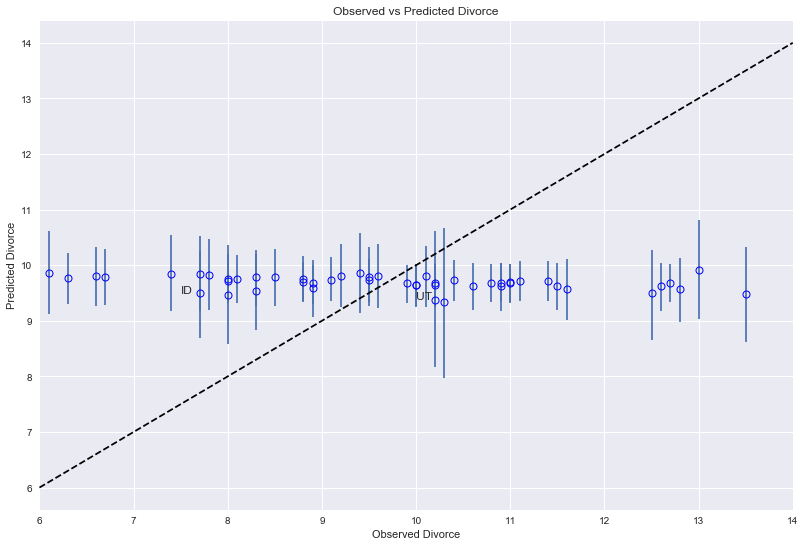

In [19]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=d["Divorce"], y=mu_mean, fmt="o", yerr=np.abs(mu_mean - mu_pi).T,
           mew=1.0, mec="b", mfc="None");
ax.plot([6, 14], [6, 14], "k--")
ax.set_title("Observed vs Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_xlim(6, 14)

ID = (d.loc[12]["Divorce"], mu_mean[12])
UT = (d.loc[43]["Divorce"], mu_mean[43])
ax.annotate("ID", ID, xytext=(ID[0]-0.2, ID[1]))
ax.annotate("UT", UT, xytext=(UT[0]-0.2, UT[1]));

### 5.14

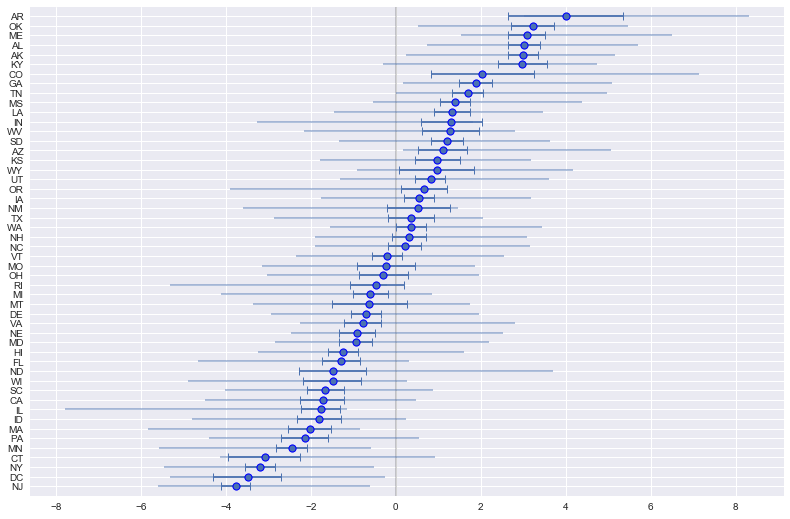

In [20]:
divorce_resid = d["Divorce"] - mu_mean.ravel()
o = np.argsort(divorce_resid)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.vlines(0, -1, len(d), alpha=0.2)
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-divorce_pi).T,
            fmt="o", mfc="C0", mew=1.0, mec="b", alpha=0.5, ecolor="C0")    
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-mu_pi).T, 
            fmt="o", capsize=4, mfc="C0", mew=1.0, mec="b", ecolor="C0")
ax.set_ylim(-1, len(d));

### 5.15

In [21]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(loc=x_real)
y = stats.norm.rvs(size=N, loc=x_real)
d = pd.DataFrame({"y": y,
                  "x_real": x_real,
                  "x_spur": x_spur})

## Masked Relationship

### 5.16

In [22]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.17

In [23]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * d["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]


RuntimeError: Chain 1 failed.

### 5.18

In [24]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### 5.19

In [25]:
dcc = d.dropna()

### 5.20

In [26]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:18<00:00, 280.87draws/s]
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### 5.21

In [27]:
pm.summary(trace_5_5, varnames=["a", "bn", "sigma"], alpha=0.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.344,0.555,0.008,-0.544,1.213,5509.877,1.0
bn,0.005,0.008,0.000,-0.009,0.017,5502.216,1.0
sigma,0.191,0.039,0.001,0.130,0.247,3509.486,1.0


### 5.22

In [28]:
trace_5_5["bn"].mean() * (76 - 55)

0.09736237916359176

### 5.23

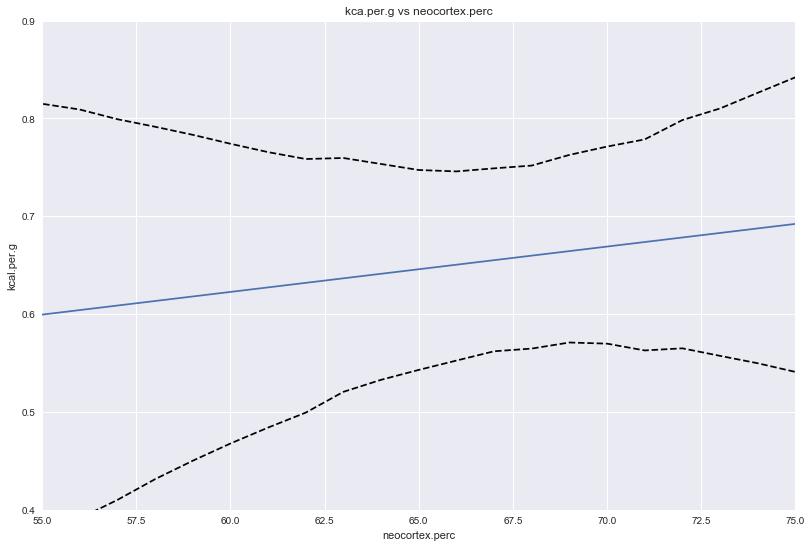

In [29]:
np_seq = np.arange(0, 100)

mu = trace_5_5["a"].reshape(-1, 1) +\
     (trace_5_5["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc")
ax.set_ylim(0.4, 0.9);

### 5.24

In [30]:
dcc["log_mass"] = np.log(dcc["mass"])

### 5.25

In [31]:
with pm.Model() as m5_6:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm * dcc["log_mass"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_6, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:15<00:00, 1380.90draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.705683,0.057006,0.000556,0.617183,0.795546,10653.022059,0.999953
bm,-0.032158,0.024037,0.000237,-0.069743,0.005178,10564.582240,1.000051
sigma,0.182814,0.037512,0.000391,0.127591,0.234477,9363.439778,1.000077


### 5.26

In [32]:
with pm.Model() as m5_7:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm*dcc["log_mass"] + bn*dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_7, varnames=["a", "bm", "bn", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [02:32<00:00, 144.65draws/s]
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7131894927010813, but should be close to 0.8. Try to increase the number of tuning steps.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.105716,0.573704,0.009435,-2.024985,-0.221401,3787.994650,0.999984
bm,-0.097249,0.027626,0.000444,-0.141149,-0.054394,4096.835404,0.999969
bn,0.028246,0.008914,0.000147,0.014273,0.042379,3704.122982,0.999981
sigma,0.139200,0.030175,0.000786,0.094691,0.183536,1197.498931,1.001754


### 5.27

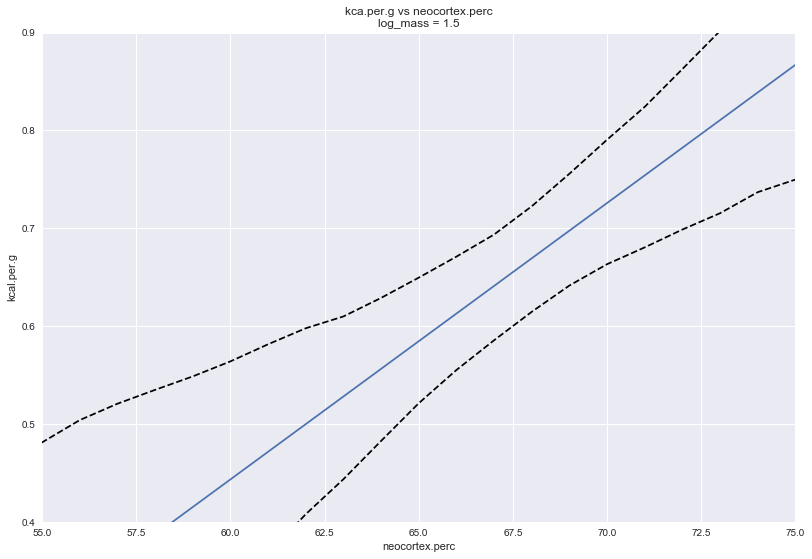

In [33]:
mean_log_mass = dcc["log_mass"].mean()
np_seq = np.arange(0, 100)

mu = trace_5_7["a"].reshape(-1, 1) +\
     (trace_5_7["bm"] * mean_log_mass).reshape(-1, 1) +\
     (trace_5_7["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc\nlog_mass = 1.5")
ax.set_ylim(0.4, 0.9);

### 5.28

In [34]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(loc=rho*x_pos, scale=np.sqrt(1-rho**2))
y = stats.norm.rvs(loc=x_pos-x_neg)
d = pd.DataFrame({"y": y,
                  "x_pos": x_pos,
                  "x_neg": x_neg})